In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from plotly.graph_objs import *
from differences import ATTgt, simulate_data

pd.set_option('display.max_columns', None)

df_results_matching_all = pd.read_parquet('data/did_matching_700.parquet')

In [3]:
df_results_matching_all.sample(5)

,sq,geometry,Nome,Linha,elegivel,T,Inauguração,ANO DO EXERCICIO,AREA OCUPADA,AREA DO TERRENO,AREA CONSTRUIDA,Area Comercial,Area Residencial - H,Area Residencial - V,Area Terreno,Residencial - H,Residencial - V,Comercial,Terreno,QUANTIDADE DE PAVIMENTOS,VALOR DO M2 DE CONSTRUCAO,VALOR DO M2 DO TERRENO,Valor,ANO DE INICIO DA VIDA DO CONTRIBUINTE,CA,TO,ano,delta,per Area Comercial,per Area Residencial - V,per Area Residencial - H,diff AREA CONSTRUIDA,diff Area Comercial,diff Area Residencial - H,diff Area Residencial - V,sum AREA CONSTRUIDA,sum Area Comercial,sum Area Residencial - H,sum Area Residencial - V,log AREA CONSTRUIDA,log Area Comercial,log Area Residencial - H,log Area Residencial - V,log Area Terreno,log VALOR DO M2 DE CONSTRUCAO,log VALOR DO M2 DO TERRENO
14038,089108,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00?\x00\x0...,Alto da Boa Vista,5,1,0,2017-06-09,2014,6908,15135,12766,4424,1405,5856,500,0.400000,0.100000,0.350000,0.050000,5.244478,647.200000,389.000000,10.269772,1979.752781,0.843475,0.456426,2017,-3,0.346546,0.458718,0.110058,0.0,0.0,0.0,0.0,5807.0,93.0,888.0,4326.0,9.454541,8.394800,7.247793,8.675222,6.214608,6.487988,5.988961
261924,051160,b'\x01\x03\x00\x00\x00\x01\x00\x00\x004\x00\x0...,São Lucas,15,1,0,2018-06-04,2006,4357,9339,5185,2694,2490,0,0,0.607143,0.000000,0.392857,0.000000,1.183414,415.607143,241.428571,2.221716,1962.621408,0.555199,0.466538,2018,-12,0.519576,0.000000,0.480231,45.0,40.0,5.0,0.0,75.0,120.0,-45.0,0.0,8.553525,7.898782,7.820038,0.000000,0.000000,6.053517,5.527159
35326,089083,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00>\x00\x0...,Borba Gato,5,1,0,2017-06-09,2011,10083,22837,24015,2806,2942,9376,0,0.437500,0.083333,0.229167,0.000000,6.701478,678.895833,375.083333,18.313886,1974.866417,1.051583,0.441520,2017,-6,0.116844,0.390423,0.122507,0.0,-110.0,110.0,0.0,2026.0,1169.0,-573.0,0.0,10.086434,7.939515,7.986845,9.145909,0.000000,6.535090,5.953460
166190,154065,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x9b\x00...,Jardim Planalto,15,1,1,2019-08-26,2008,5028,10746,7011,0,7010,0,627,0.951613,0.000000,0.000000,0.048387,1.523606,381.677419,89.000000,2.926950,1981.143346,0.652429,0.467895,2019,-11,0.000000,0.000000,0.999857,253.0,0.0,253.0,0.0,1303.0,0.0,1303.0,0.0,8.855236,0.000000,8.855093,0.000000,6.440947,5.970439,4.595120
89639,168164,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,Campo Limpo,5,1,1,2002-10-20,2022,3770,10169,4378,0,4089,0,289,0.957447,0.000000,0.000000,0.021277,1.461855,1226.063830,456.638298,5.580643,1974.907720,0.430524,0.370735,2002,20,0.000000,0.000000,0.933988,0.0,0.0,0.0,0.0,656.0,0.0,368.0,0.0,8.384347,0.000000,8.316056,0.000000,5.666427,7.119687,6.145554


In [4]:
# remover largo treze e pinheiros
ls_central = [
# lilas
#     'Adolfo Pinheiro',
    'AACD-Servidor',
    'Alto da Boa Vista',
    'Borba Gato', 
    'Brooklin', 
    'Campo Belo',
    'Moema',
    'Eucaliptos',
    'Hospital São Paulo',
#     amarela
    'Faria Lima',
    'Fradique Coutinho',
    'Oscar Freire',
    'Higienópolis–Mackenzie',
#     verde
    'Vila Madalena',
    'Sumaré',
    'Chácara Klabin',
]
ls_perif = [
# 
#     'Butantã',
    'Vila Sônia',
#     'São Paulo-Morumbi',
#  azul
    'Tucuruvi',
    'Parada Inglesa',
#     'Jardim São Paulo',
#     verde
    'Alto do Ipiranga',
#     'Chácara Klabin',
    'Sacomã',
#     'Santos-Imigrantes',
    'Tamanduateí',
    'Vila Prudente',
#     Lilas
    'Campo Limpo',
    'Capão Redondo',
    'Giovanni Gronchi',
#     'Largo Treze',
    'Santo Amaro',
    'Vila das Belezas',
#     'Adolfo Pinheiro',
#     'Alto da Boa Vista',
    # prata
    'Camilo Haddad',
    'Fazenda da Juta',
    'Jardim Colonial',
    'Jardim Planalto',
    'Oratório',
    'Sapopemba',
    'São Lucas',
    'São Mateus',
    'Vila Tolstói',
    'Vila União',
]

df_results_matching_all['centro'] = (df_results_matching_all.Nome.isin(ls_central)).astype(int)
df_results_matching_all['perif'] = (df_results_matching_all.Nome.isin(ls_perif)).astype(int)

In [5]:
list(set(df_results_matching_all.Nome.unique()) - set(df_results_matching_all[df_results_matching_all['centro'] == 1].Nome.unique()) - set(df_results_matching_all[df_results_matching_all['perif'] == 1].Nome.unique()) )

['Butantã',
 'São Paulo-Morumbi',
 'Pinheiros',
 'Largo Treze',
 'Adolfo Pinheiro',
 'Santos-Imigrantes',
 'Jardim São Paulo']

In [6]:
df_means = df_results_matching_all[(df_results_matching_all[['centro', 'perif']].sum(axis=1) == 1) & (df_results_matching_all.delta == -3)]
df_means = (
    df_means
    .groupby(['T', 'centro', 'perif'])['Area Comercial']
    .mean()
    .reset_index(name='Area Comercial_mean')
)

df_results_matching_all = df_results_matching_all.merge(df_means, on=['T', 'perif', 'centro'], how='inner')
df_results_matching_all['rel2 Area Comercial'] = df_results_matching_all['Area Comercial'] / df_results_matching_all['Area Comercial_mean']

In [7]:
df_results_matching_all['opening-year'] = df_results_matching_all.Inauguração.dt.year
df_results_matching_all['time'] = df_results_matching_all['ANO DO EXERCICIO']

In [8]:
df_results_matching_all['cohort'] = (df_results_matching_all['opening-year'] * df_results_matching_all['T']).apply(lambda x: x if x != 0 else np.nan)

In [9]:
df_results_matching_all = df_results_matching_all.set_index(['sq', 'time'])

In [10]:
df_results_matching_all['rel Area Comercial'] = df_results_matching_all['Area Comercial'] / df_results_matching_all[df_results_matching_all.delta == -3]['Area Comercial'].mean() * 100
df_results_matching_all['rel Area Residencial - H'] = df_results_matching_all['Area Residencial - H'] / df_results_matching_all[df_results_matching_all.delta == -3]['Area Residencial - H'].mean() * 100

In [11]:
df_results_alta = df_results_matching_all[df_results_matching_all.Nome.isin(ls_central)]
df_results_baixa = df_results_matching_all[df_results_matching_all.Nome.isin(ls_perif)]

In [12]:
df_results_matching_all['CA'].mean(), df_results_matching_all['CA'].std()

(1.0036129014123045, 0.8266229507355107)

In [13]:
df_results_matching_all['rel2 Area Comercial'].mean(), df_results_matching_all['rel2 Area Comercial'].std()

(0.9712579111629752, 2.8558495876305776)

In [14]:
def mp_did(df_results, y):
    df_did = df_results.copy()
    df_did['y'] = df_did[y]
    att_gt = ATTgt(df_did, cohort_name='cohort')
    att_gt.fit(formula='y', n_jobs=20, random_state=42, 
               control_group='not_yet_treated'
              )
    return att_gt

att_gt_baixa_ca = mp_did(df_results_baixa, 'CA')
att_gt_alta_ca = mp_did(df_results_alta, 'CA')

att_gt_baixa_ac = mp_did(df_results_baixa, 'rel2 Area Comercial')
att_gt_alta_ac = mp_did(df_results_alta, 'rel2 Area Comercial')

Computing ATTgt [workers=20]  100%|████████████████████| 210/210 [00:13<00:00, 15.98it/s]


In [15]:
def get_dfplot(att_gt):
    # Aggregate for two confidence levels
    df5 = att_gt.aggregate("event", alpha=0.05)
    df10 = att_gt.aggregate("event", alpha=0.10)

    # Flatten MultiIndex columns and rename
    df5.columns = ["coef", "std_error_5", "LB_5", "UB_5", "relevance_5"]
    df10.columns = ["coef_10", "std_error_10", "LB_10", "UB_10", "relevance_10"]

    # Reset index to bring cohort into column
    df5 = df5.reset_index().rename(columns={"index": "cohort"})
    df10 = df10.reset_index().rename(columns={"index": "cohort"})
    # Merge the two DataFrames on cohort
    df_merged = pd.merge(df5, df10, on="relative_period", how="outer")
    return df_merged

df_did_plot_baixa_ca = get_dfplot(att_gt_baixa_ca)
df_did_plot_alta_ca = get_dfplot(att_gt_alta_ca)

df_did_plot_baixa_ac = get_dfplot(att_gt_baixa_ac)
df_did_plot_alta_ac = get_dfplot(att_gt_alta_ac)

In [16]:
import matplotlib.colors as colors
import matplotlib.lines as mlines


verde_esmeralda_2 = {
    "verde_escuro": "#1B7F60",
    "verde_principal": "#25AC82",
    "verde_claro": "#5FC9A6",
}

amarelo_2 = {
    "amarelo_escuro": "#BFA800",
    "amarelo": '#E8D202'
}

cmap_amarelo_2 = colors.ListedColormap(list(amarelo_2.values()))
cmap_verde_2 = colors.ListedColormap(list(verde_esmeralda_2.values()))


def many_distance_plot(df_center, df_perif, title, dt_ini=-3, dt_end=15, save=False, x=100):
    # Filter relative periods
    df_res_center = df_center[(df_center.relative_period >= dt_ini) & (df_center.relative_period <= dt_end)].copy()
    df_res_perif = df_perif[(df_perif.relative_period >= dt_ini) & (df_perif.relative_period <= dt_end)].copy()

    # Colors
    color_center = cmap_amarelo_2.colors[1]
    color_perif = cmap_verde_2.colors[1]

    fig, ax = plt.subplots(figsize=(16, 9))
    # Grid & style
    ax.grid(axis='x', color='grey', linestyle='-', linewidth=0.01)
    ax.grid(axis='y', color='grey', linestyle='-', linewidth=0.3)
    for sp in ['top', 'right', 'bottom', 'left']:
        ax.spines[sp].set_visible(False)

    # Axis labels
    ax.set_xlabel('Relative-to-treatment time (years)', color='black')
    ax.set_ylabel('ATT (%)', color='black')
    ax.tick_params(colors='black')

    # Zero reference line
    ax.axhline(0, color='grey', linewidth=1)
    ax.axvline(0, color='grey', linewidth=1, alpha=0.3)
    
    # Prepare data arrays
    rp_center = df_res_center['relative_period'].values
    rp_perif = df_res_perif['relative_period'].values
    # Point estimates
    coefs_center = df_res_center['coef'].values * x
    coefs_perif = df_res_perif['coef'].values * x
    # 5% CI
    lb5_center = df_res_center['LB_5'].values * x
    ub5_center = df_res_center['UB_5'].values * x
    lb5_perif = df_res_perif['LB_5'].values * x
    ub5_perif = df_res_perif['UB_5'].values * x
    # 10% CI
    lb10_center = df_res_center['LB_10'].values * x
    ub10_center = df_res_center['UB_10'].values * x
    lb10_perif = df_res_perif['LB_10'].values * x
    ub10_perif = df_res_perif['UB_10'].values * x

    # Offsets for separation
    offset = 0.0
    rp_center_off = rp_center - offset
    rp_perif_off = rp_perif + offset

    # Plot 10% (outer) shaded intervals with dashed contour
    ax.fill_between(rp_center_off, lb10_center, ub10_center,
                    facecolor=color_center, alpha=0.05)
    ax.plot(rp_center_off, lb10_center, linestyle='--', color=color_center, alpha=0.45)
    ax.plot(rp_center_off, ub10_center, linestyle='--', color=color_center, alpha=0.45)

    ax.fill_between(rp_perif_off, lb10_perif, ub10_perif,
                    facecolor=color_perif, alpha=0.05)
    ax.plot(rp_perif_off, lb10_perif, linestyle='--', color=color_perif, alpha=0.45)
    ax.plot(rp_perif_off, ub10_perif, linestyle='--', color=color_perif, alpha=0.45)

    # Plot 5% (inner) shaded intervals with dashed contour
    ax.fill_between(rp_center_off, lb5_center, ub5_center,
                    facecolor=color_center, alpha=0.03)
    ax.plot(rp_center_off, lb5_center, linestyle=':', color=color_center, linewidth=1.5, alpha=0.45)
    ax.plot(rp_center_off, ub5_center, linestyle=':', color=color_center, linewidth=1.5, alpha=0.45)

    ax.fill_between(rp_perif_off, lb5_perif, ub5_perif,
                    facecolor=color_perif, alpha=0.03)
    ax.plot(rp_perif_off, lb5_perif, linestyle=':', color=color_perif, linewidth=1.5, alpha=0.45)
    ax.plot(rp_perif_off, ub5_perif, linestyle=':', color=color_perif, linewidth=1.5, alpha=0.45)

    # Plot lines with markers
    ax.plot(rp_center_off, coefs_center, '-o', color=color_center,
            markersize=9, markeredgecolor=cmap_amarelo_2.colors[0], alpha=0.8)
    ax.plot(rp_perif_off, coefs_perif, '-o', color=color_perif,
            markersize=9, markeredgecolor=cmap_verde_2.colors[0], alpha=0.8)
    
    region_center = mlines.Line2D([], [], color=color_center, marker='o', linestyle='-', markersize=9,
                                  markeredgecolor=cmap_amarelo_2.colors[0], label='Central Region')
    region_perif = mlines.Line2D([], [], color=color_perif, marker='o', linestyle='-', markersize=9,
                                 markeredgecolor=cmap_verde_2.colors[0], label='Peripheral Region')
    ci10 = mlines.Line2D([], [], color='grey', linestyle='--', label='90% CI')
    ci5 = mlines.Line2D([], [], color='grey', linestyle=':', label='95% CI')
    ax.legend(handles=[region_center, region_perif, ci10, ci5], loc='upper left', frameon=True)
    # X-axis ticks and labels
    ax.set_xticks(rp_perif)
    ax.set_xticklabels(rp_perif)

    # Title
    ax.set_title(title, color='black')

    if save:
        fig.savefig(f"figs/{title}.png", bbox_inches='tight')
    return fig, ax

(<Figure size 1152x648 with 1 Axes>,
 <Axes: title={'center': 'MP-DID (not yet treated) - Floor Area Ratio'}, xlabel='Relative-to-treatment time (years)', ylabel='ATT (%)'>)

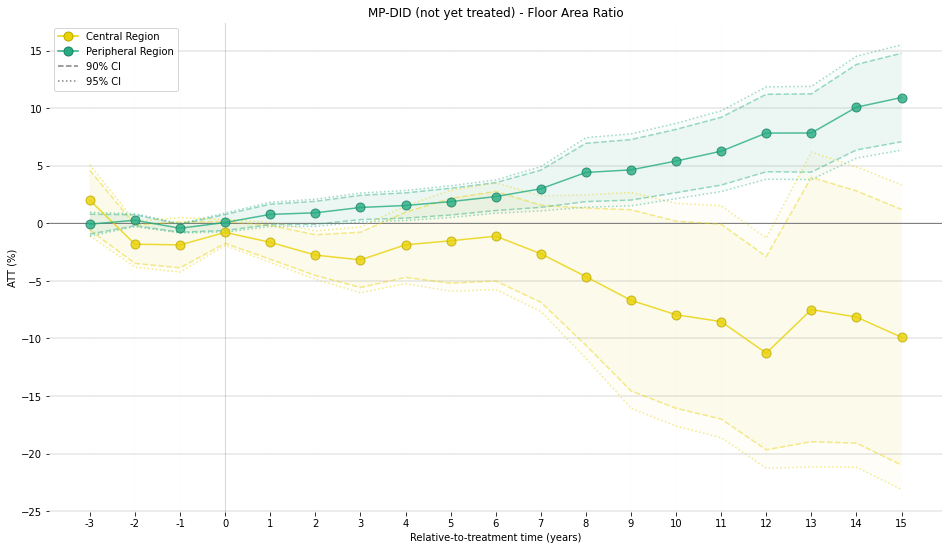

In [18]:
many_distance_plot(df_did_plot_alta_ca, df_did_plot_baixa_ca, 'MP-DID (not yet treated) - Floor Area Ratio', save=True)

(<Figure size 1152x648 with 1 Axes>,
 <Axes: title={'center': 'MP-DID (not yet treated) - Commercial Area'}, xlabel='Relative-to-treatment time (years)', ylabel='ATT (%)'>)

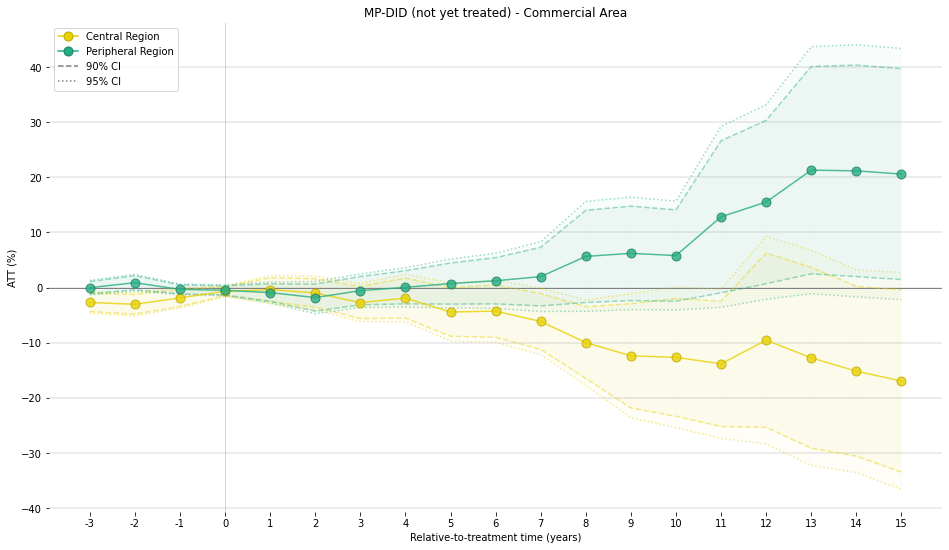

In [19]:
many_distance_plot(df_did_plot_alta_ac, df_did_plot_baixa_ac, 'MP-DID (not yet treated) - Commercial Area', save=True)